In [172]:
from transformers import pipeline
import torch
from torch.utils.data import DataLoader
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, udf, col
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers import SentenceTransformer, util

In [173]:
spark = SparkSession.builder \
        .appName("test_case") \
        .getOrCreate()

In [174]:
from pyspark.sql import SparkSession

# Initialize Spark session
# spark = SparkSession.builder.appName("NewsDataProcessing").getOrCreate()

# List of news sources and their CSV file paths
news_sources = [
    ("cnn", "waffle-iron/ml_data/cnn.csv"),
    ("foxnews", "waffle-iron/ml_data/foxnews.csv"),
    ("bbc", "waffle-iron/ml_data/bbc.csv"),
    ("nytimes", "waffle-iron/ml_data/nytimes.csv"),
    ("theguardian", "waffle-iron/ml_data/theguardian.csv"),
    ("washingtonpost", "waffle-iron/ml_data/washingtonpost.csv"),
    ("wsj", "waffle-iron/ml_data/wsj.csv")
]

processed_dfs = {}
for name, path in news_sources:
    df = spark.read.option("multiline", "true").csv(path, header=True)
    processed_df = df.select("title", "text", "short_description").na.drop(subset=["text"]).withColumn("text", regexp_replace(df["text"], "\n\n", " "))
    processed_dfs[name] = processed_df

In [175]:
def compute_similarity(title, text):
    sentences = sent_tokenize(text)

    # Generate embedding for the title outside the loop
    title_embedding = model.encode(title)

    max_similarity = float("-inf")
    associated_sentence = ""
    similarities = []

    for sentence in sentences:
        # Generate embedding for each sentence
        sentence_embedding = model.encode(sentence)

        # Compute similarity
        similarity = util.cos_sim(title_embedding, sentence_embedding)
        similarity_value = similarity.item()  # Extract the scalar value

        if similarity_value > max_similarity:
            max_similarity = similarity_value
            associated_sentence = sentence

        similarities.append(similarity_value)

    average_similarity = np.mean(similarities) if similarities else 0
    sorted_similarities = sorted(similarities, reverse=True)

    return sorted_similarities, average_similarity, max_similarity, len(sentences)

In [176]:
results_df = pd.DataFrame(columns=["News Source", "Total Similarity Sum", "Avg Number Sentences", "Overall Avg Similarity"])

### CNN:

In [177]:
cnn_processed_df = processed_dfs["cnn"]
cnn_processed_df = cnn_processed_df.withColumn("short_description", regexp_replace(cnn_processed_df["short_description"], r"\s+CNN$", "")).withColumn("text", regexp_replace(cnn_processed_df["text"], r'\s*(\w+)\s+\w+/\w+$', ''))
cnn_processed_df.show(2, truncate=False)

+------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [178]:
# Compute similarity for CNN articles
model_name = "Sakil/sentence_similarity_semantic_search"
model = SentenceTransformer(model_name)
n_articles = 40
rows = cnn_processed_df.limit(n_articles).collect()
total_similarity_sum_cnn = 0
total_articles_cnn = 0
avg_sentence_length = 0

for row in rows:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    total_similarity_sum_cnn += np.mean(sorted_similarities[:3])
    total_articles_cnn += 1
    avg_sentence_length += n_sentences

overall_avg_similarity_cnn = total_similarity_sum_cnn / total_articles_cnn

new_row = {
    "News Source": "CNN",
    "Total Similarity Sum": total_similarity_sum_cnn,
    "Avg Number Sentences": avg_sentence_length/n_articles,
    "Overall Avg Similarity": overall_avg_similarity_cnn
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

### Fox News:


In [179]:
fox_processed_df = processed_dfs["foxnews"]
fox_processed_df = fox_processed_df.withColumn(
    "text", 
    regexp_replace(
        "text", 
        "Join Fox News for access to this content Plus special access to select articles and other premium content with your account - free of charge. Please enter a valid email address. ", 
        ""
    )
).withColumn(
    "text", 
    regexp_replace(
        "text", 
        "CLICK HERE TO GET THE FOX NEWS APP", 
        ""
    )
)
fox_processed_df.show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                                                                                      |text                                                                                      

In [180]:
model_name = "Sakil/sentence_similarity_semantic_search"
model = SentenceTransformer(model_name)
n_articles = 40
rows = fox_processed_df.limit(n_articles).collect()
total_similarity_sum_fox = 0
total_articles_fox = 0
avg_sentence_length = 0

for row in rows:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    total_similarity_sum_fox += np.mean(sorted_similarities[:3])
    total_articles_fox += 1
    avg_sentence_length += n_sentences


overall_avg_similarity_fox = total_similarity_sum_fox / total_articles_fox

new_row = {
    "News Source": "Fox",
    "Total Similarity Sum": total_similarity_sum_fox,
    "Avg Number Sentences": avg_sentence_length/n_articles,
    "Overall Avg Similarity": overall_avg_similarity_fox
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

### The Guardian:

In [181]:
guardian_processed_df = processed_dfs["theguardian"]
guardian_processed_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [182]:
model_name = "Sakil/sentence_similarity_semantic_search"
model = SentenceTransformer(model_name)
n_articles = 40
rows = guardian_processed_df.limit(n_articles).collect()
total_similarity_sum_guardian = 0
total_articles_guardian = 0
avg_sentence_length = 0

for row in rows:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    total_similarity_sum_guardian += np.mean(sorted_similarities[:3])
    total_articles_guardian += 1
    avg_sentence_length += n_sentences

overall_avg_similarity_guardian = total_similarity_sum_guardian / total_articles_guardian

new_row = {
    "News Source": "The Guardian",
    "Total Similarity Sum": total_similarity_sum_guardian,
    "Avg Number Sentences": avg_sentence_length/n_articles,
    "Overall Avg Similarity": overall_avg_similarity_guardian
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [183]:
wpost_processed_df = processed_dfs["washingtonpost"]
wpost_processed_df = wpost_processed_df.withColumn("text", regexp_replace(wpost_processed_df["text"], r'\bAdvertisement\b', ''))
wpost_processed_df.show(10, truncate=False)

+---------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [184]:
model_name = "Sakil/sentence_similarity_semantic_search"
model = SentenceTransformer(model_name)
n_articles = 40
rows = wpost_processed_df.limit(n_articles).collect()
total_similarity_sum_wpost = 0
total_articles_wpost = 0
avg_sentence_length = 0

for row in rows:
    title = row["title"]
    text = row["text"]
    sorted_similarities, average_similarity, max_similarity, n_sentences = compute_similarity(title, text)
    total_similarity_sum_wpost += np.mean(sorted_similarities[:3])
    total_articles_wpost += 1
    avg_sentence_length += n_sentences

overall_avg_similarity_wpost = total_similarity_sum_wpost/ total_articles_wpost

new_row = {
    "News Source": "Washington Post",
    "Total Similarity Sum": total_similarity_sum_wpost,
    "Avg Number Sentences": avg_sentence_length/n_articles,
    "Overall Avg Similarity": overall_avg_similarity_wpost
}
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [185]:
results_df

,News Source,Total Similarity Sum,Avg Number Sentences,Overall Avg Similarity
0,CNN,13.385794,8.275,0.334645
1,Fox,10.578840,2.125,0.264471
2,The Guardian,15.341941,31.825,0.383549
3,Washington Post,17.327652,47.325,0.433191


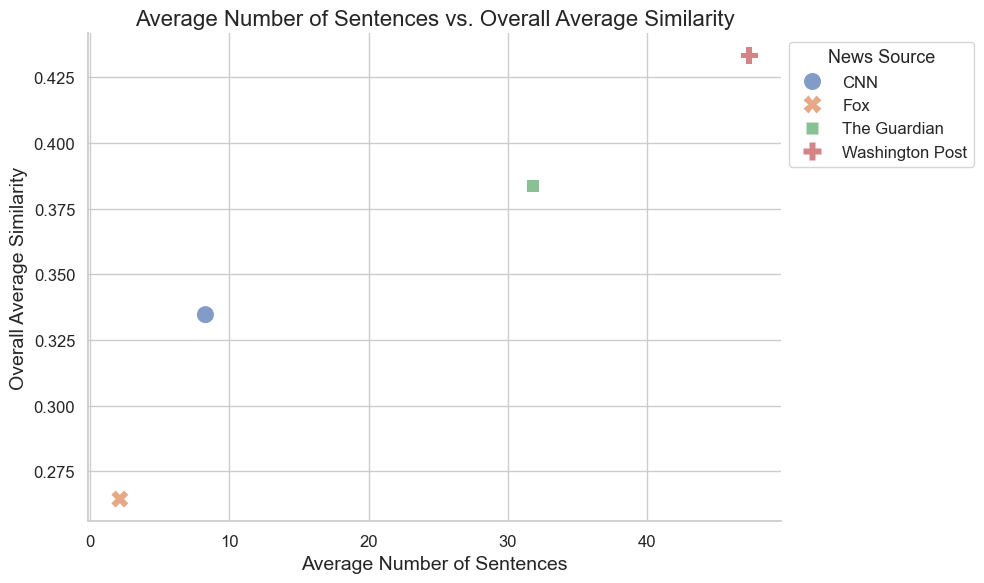

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x="Avg Number Sentences", y="Overall Avg Similarity", hue="News Source", 
                          data=results_df, style="News Source", s=150, palette="deep", 
                          edgecolor="none", alpha=0.7)

plt.title("Average Number of Sentences vs. Overall Average Similarity", fontsize=16)
plt.ylabel("Overall Average Similarity", fontsize=14)
plt.xlabel("Average Number of Sentences", fontsize=14)

plt.legend(title='News Source', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()


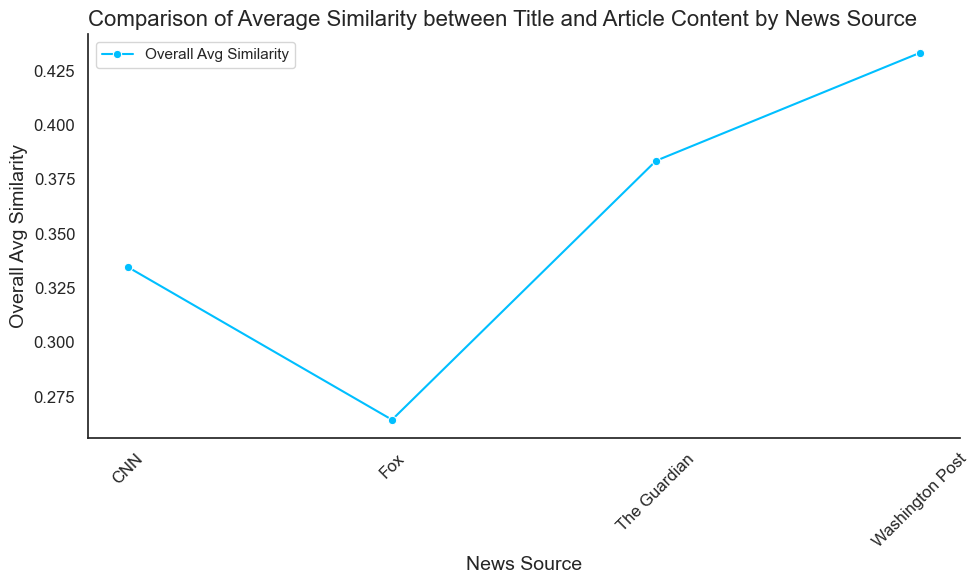

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall aesthetics
sns.set(style="white")

# Create a larger figure for better visibility
plt.figure(figsize=(10, 6))

# Plot the first line for Overall Avg Similarity
ax1 = sns.lineplot(x="News Source", y="Overall Avg Similarity", data=results_df, marker="o", color="deepskyblue", label="Overall Avg Similarity")
ax1.set_title("Comparison of Average Similarity between Title and Article Content by News Source", fontsize=16, loc = 'left')
ax1.set_xlabel("News Source", fontsize=14)
ax1.set_ylabel("Overall Avg Similarity", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45)

sns.despine()
lines_1, labels_1 = ax1.get_legend_handles_labels()
plt.tight_layout()
plt.show()


In [186]:
# tokenizer = Tokenizer(inputCol="text", outputCol="words")
# fox_selected_df = tokenizer.transform(fox_selected_df)

# remover = StopWordsRemover(inputCol="words", outputCol="clean_words")
# fox_selected_df = remover.transform(fox_selected_df)

# fox_selected_df = fox_selected_df.withColumn("clean_text", col("clean_words").cast("string"))

# fox_selected_df = fox_selected_df.drop("words", "clean_words", "clean_text")

# def tokenize_title(title):
#     return word_tokenize(title)
# tokenize_title_udf = udf(tokenize_title, ArrayType(StringType()))
# fox_selected_df = fox_selected_df.withColumn("title_tokens", tokenize_title_udf("title"))

# fox_selected_df.show(2, truncate=False)

In [187]:
# def nltk_sentence_tokenize(text):
#     sentences = nltk.sent_tokenize(text)
#     return sentences

# sentence_tokenize_udf = udf(nltk_sentence_tokenize, ArrayType(StringType()))
# fox_selected_df = fox_selected_df.withColumn("sentences", sentence_tokenize_udf(fox_selected_df["text"]))
# fox_selected_df.select("sentences").collect()[0]

In [188]:
# this code doesn't work for some reason, think there's some issues converting the similarity scores to a format that can append to pyspark df

# def compute_similarity(title, text):
#     title_tokens = word_tokenize(title)
#     sentences = nltk.sent_tokenize(text)

#     similarity_sum = 0
#     for sentence in sentences:
#         sentence_tokens = word_tokenize(sentence)
#         title_embedding = model.encode(title_tokens)
#         sentence_embedding = model.encode(sentence_tokens)

#         similarity = util.cos_sim(title_embedding, sentence_embedding)
#         similarity_sum += similarity[0][0]

#     average_similarity = similarity_sum / len(sentences)
#     return average_similarity

# compute_similarity_udf = udf(compute_similarity, \
#                              returnType=FloatType())

# result_df = fox_selected_df.withColumn("average_similarity", compute_similarity_udf("title", "text"))
# result_df.show(truncate=False)

In [189]:
spark.stop()